### **Load the dataset**

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"landaooo","key":"aea06998007bdfa52b69e623c174c352"}'}

In [ ]:
# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d pkdarabi/bone-break-classification-image-dataset
!unzip bone-break-classification-image-dataset.zip -d bone_fracture_dataset

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/28.4M [00:00<?, ?B/s]
100% 28.4M/28.4M [00:00<00:00, 666MB/s]
Archive:  bone-break-classification-image-dataset.zip
  inflating: bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0.jpg  
  inflating: bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/05cc2e0302957e0ad27edb6b9ffbc2_jumbo_jpg.rf.c15eb3758845b639f3aaba73c373501d.jpg  
  inflating: bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/1-s2-0-S0899707114002836-gr2_jpg.rf.bb8ed4dee892edbb760f6ce687d74ba5.jpg  
  inflating: bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a35a0cac6f45.jpg  
  infla

In [ ]:
import os

base_path = "bone_fracture_dataset"
for root, dirs, files in os.walk(base_path):
    print(f"{root} has {len(dirs)} folders and {len(files)} files")

bone_fracture_dataset has 1 folders and 1 files
bone_fracture_dataset/Bone Break Classification has 1 folders and 0 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification has 10 folders and 0 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Greenstick fracture has 2 folders and 0 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Greenstick fracture/Train has 0 folders and 106 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Greenstick fracture/Test has 0 folders and 16 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture has 2 folders and 0 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture/Train has 0 folders and 101 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture/Test has 0 folders and 10 files
bone_fracture_dataset/Bone Break Cl

In [ ]:
import shutil
import os

# Path to the correct level
fracture_path = "bone_fracture_dataset/Bone Break Classification/Bone Break Classification"

# Create a new directory for combined training
os.makedirs("combined_train", exist_ok=True)

# Loop through each fracture type
for fracture_type in os.listdir(fracture_path):
    full_path = os.path.join(fracture_path, fracture_type, "Train")
    if os.path.isdir(full_path):
        dest = os.path.join("combined_train", fracture_type)
        os.makedirs(dest, exist_ok=True)
        for file in os.listdir(full_path):
            shutil.copy(os.path.join(full_path, file), os.path.join(dest, file))

### **Configure the dataset for performance**

In [ ]:
# Define augmentation as a Sequential layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

In [ ]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
# Apply 'data_augmentation' to the training images
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls = tf_data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf_data.AUTOTUNE)

### **Make a Model**

In [ ]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape = input_shape)

  # Entry block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(128, 3, strides = 2, padding = "same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x # Set aside residual

  for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual]) # Add back residual
    previous_block_activation = x # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    units = 1
  else:
    units = num_classes

  x = layers.Dropout(0.25)(x)

  # We specify activation=None so as to return logits
  outputs = layers.Dense(units, activation=None)(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=10)
#keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

model.compile(
    optimizer = keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [keras.metrics.SparseCategoricalAccuracy(name = "acc")],
)

history = model.fit(
    train_ds,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_ds,
)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - acc: 0.1382 - loss: 2.3657 - val_acc: 0.1168 - val_loss: 2.2999
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - acc: 0.1867 - loss: 2.2499 - val_acc: 0.1168 - val_loss: 2.2985
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - acc: 0.1980 - loss: 2.1706 - val_acc: 0.1269 - val_loss: 2.2974
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - acc: 0.2389 - loss: 2.1201 - val_acc: 0.1371 - val_loss: 2.2965
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.2307 - loss: 2.1098 - val_acc: 0.1371 - val_loss: 2.2955
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.2478 - loss: 2.1023 - val_acc: 0.1371 - val_loss: 2.2949
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.2747 - loss: 2.0670 - val_acc: 0.1371 - val_loss: 2.2940
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.3097 - loss: 1.9638 - val_acc: 0.1371 - val_loss: 2.2935
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.2745 - loss:

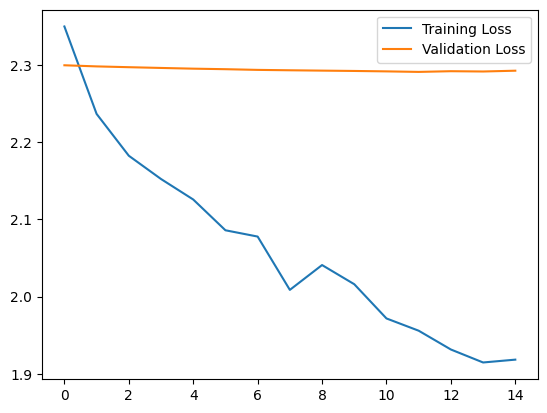

In [ ]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

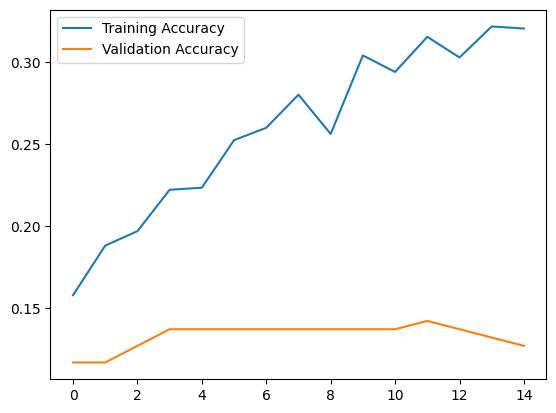

In [ ]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()

### **Transfer Learning**

#### **MobileNetV2 (baseline)**

In [ ]:
def make_transfer_model(input_shape, num_classes):
  # Load the pre-trained weights of MobileNetV2 and freeze the weights
  backbone = keras.applications.MobileNetV2(
      weights = "imagenet",
      include_top=False,
      input_shape=input_shape,
  )

  backbone.trainable = False

  inputs = layers.Input(input_shape)
  x = keras.applications.mobilenet_v2.preprocess_input(inputs)
  x = backbone(x)
  x = layers.Dropout(0.3)(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    units = 1
  else:
    units = num_classes

  x = layers.Dropout(0.25)(x)
  # We specify activation=None so as to return logits
  outputs = layers.Dense(units, activation=None)(x)
  return keras.Model(inputs, outputs, name="keypoint_detector")

model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=10)

/tmp/ipython-input-19-641995328.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

model2.compile(
    optimizer = keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = [keras.metrics.SparseCategoricalAccuracy(name = "acc")],
)

history = model2.fit(
    train_ds,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_ds,
)

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - acc: 0.0609 - loss: 3.0384 - val_acc: 0.1117 - val_loss: 2.4602
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.1409 - loss: 2.6050 - val_acc: 0.1371 - val_loss: 2.4070
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.1206 - loss: 2.5730 - val_acc: 0.1726 - val_loss: 2.3687
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.1390 - loss: 2.4254 - val_acc: 0.1726 - val_loss: 2.3284
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.1687 - loss: 2.3332 - val_acc: 0.1827 - val_loss: 2.2643
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.1615 - loss: 2.4225 - val_acc: 0.1929 - val_loss: 2.2380
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.1661 - loss: 2.3160 - val_acc: 0.2081 - val_loss: 2.1974
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.2075 - loss: 2.3025 - val_acc: 0.2234 - val_loss: 2.1768
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.2261 - loss: 

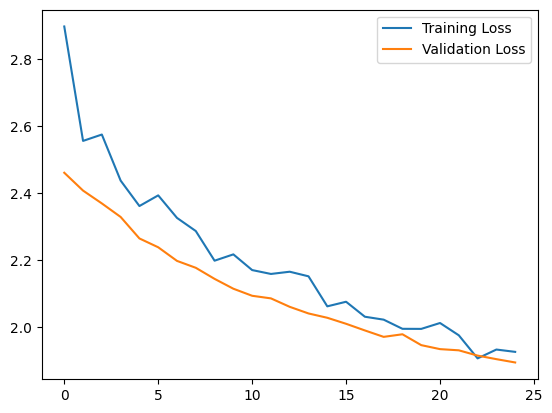

In [ ]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

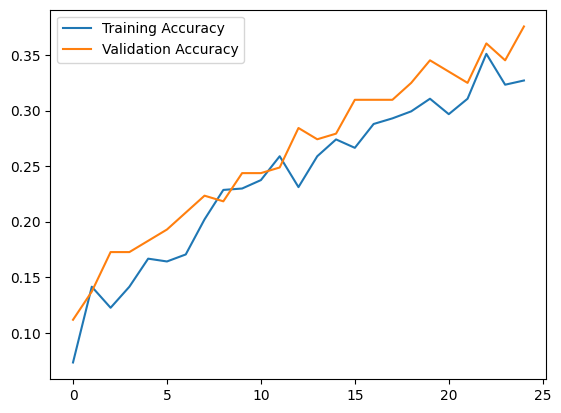

In [ ]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()

### **MobileNetV2 (fixing a bit)**

<Axes: title={'center': 'Class Distribution'}>

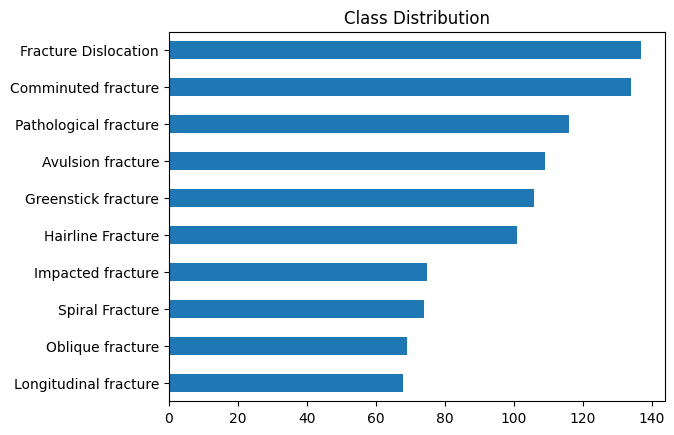

In [ ]:
import pandas as pd

class_counts = {}
for folder in os.listdir("combined_train"):
    class_path = os.path.join("combined_train", folder)
    class_counts[folder] = len(os.listdir(class_path))

pd.Series(class_counts).sort_values().plot(kind='barh', title='Class Distribution')

In [ ]:
# Re-load the raw training dataset (no map(), no prefetch)
raw_train_ds = keras.utils.image_dataset_from_directory(
    "combined_train",
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=40
)

Found 989 files belonging to 10 classes.
Using 792 files for training.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class names
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# Extract all labels from the dataset
all_labels = []
for _, labels in raw_train_ds.unbatch():
    all_labels.append(labels.numpy())

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=all_labels
)

# Convert to dictionary
class_weights = dict(enumerate(class_weights))

In [ ]:
# Unfreeze top 50 layers for fine-tuning
model2.get_layer("mobilenetv2_1.00_224").trainable = True
for layer in model2.get_layer("mobilenetv2_1.00_224").layers[:-50]:
    layer.trainable = False

# Recompile with lower LR for fine-tuning
model2.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

In [ ]:
history_finetune = model2.fit(
    train_ds,
    epochs=15,
    validation_data=validation_ds,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.2986 - loss: 2.0122 - val_acc: 0.3807 - val_loss: 1.8463
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.3646 - loss: 1.9422 - val_acc: 0.3807 - val_loss: 1.8422
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.3408 - loss: 1.9377 - val_acc: 0.3858 - val_loss: 1.8381
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.3596 - loss: 1.8805 - val_acc: 0.3959 - val_loss: 1.8324
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.3585 - loss: 1.8703 - val_acc: 0.3959 - val_loss: 1.8278
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1000ms/step - acc: 0.3104 - loss: 1.9044 - val_acc: 0.3909 - val_loss: 1.8242
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.3374 - loss: 1.8874 - val_acc: 0.3858 - val_loss: 1.8209
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.3930 - loss: 1.7997 - val_acc: 0.3959 - val_loss: 1.8152
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.3212 - lo

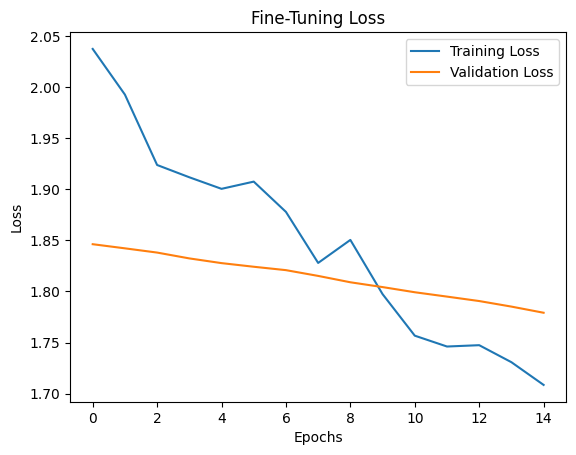

In [ ]:
plt.plot(range(len(history_finetune.history["loss"])), history_finetune.history["loss"], label="Training Loss")
plt.plot(range(len(history_finetune.history["val_loss"])), history_finetune.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Fine-Tuning Loss")
plt.legend()
plt.show()

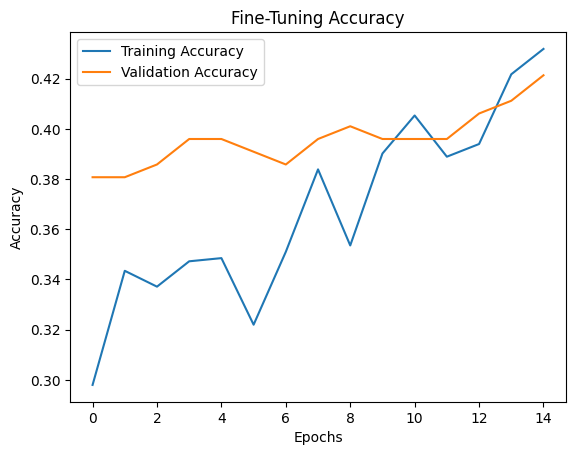

In [ ]:
plt.plot(range(len(history_finetune.history["acc"])),history_finetune.history["acc"],label="Training Accuracy")
plt.plot(range(len(history_finetune.history["val_acc"])),history_finetune.history["val_acc"],label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Fine-Tuning Accuracy")
plt.legend()
plt.show()